In [32]:
import pandas as pd
from dateutil.relativedelta import relativedelta
import numpy as np
import re
import matplotlib.pyplot as plt
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import warnings
warnings.filterwarnings("ignore")
import math
import os
from datetime import date, timedelta, datetime
import time
from tqdm import tqdm
import seaborn as sns
from scipy import stats
import xlsxwriter
from matplotlib.ticker import MaxNLocator
from matplotlib.backends.backend_pdf import PdfPages
start_time = time.perf_counter()

In [33]:
price_data = pd.read_csv('stockPriceData.csv')
price_data_500 = price_data.groupby('Date', group_keys=False).apply(lambda x: x.sort_values(by='Mcap', ascending=False).head(500))
df = price_data_500.copy()
df['Date'] = pd.to_datetime(df['Date'])

master_date = df.drop_duplicates(subset='Date')[['Date']].reset_index(drop=True)
df.set_index('Date', inplace=True)

# Step 1: Sort by Date and descending Mcap (higher Mcap = rank 1)
df = df.sort_values(by=['Date', 'Mcap'], ascending=[True, False])

# Step 2: Create daily rank
df['Daily_Mcap_Rank'] = df.groupby('Date')['Mcap'].rank(method='first', ascending=False)

# Step 3: Define classification function
def classify_mcap(rank):
    if rank <= 100:
        return 'Large'
    elif rank <= 250:
        return 'Mid'
    else:
        return 'Small'

# Step 4: Apply classification
df['Mcap_Category'] = df['Daily_Mcap_Rank'].apply(classify_mcap)
df = df.sort_values(['Symbol', 'Date'])
df['PrevClose'] = df.groupby('Symbol')['Close'].shift(1)
df['returns'] = (df['Close'] - df['PrevClose']) / df['PrevClose']
df

,Symbol,Open,High,Low,Close,Volume,Mcap,Daily_Mcap_Rank,Mcap_Category,PrevClose,returns
Date,,,,,,,,,,,
2019-09-19,360ONE,1210.000,1270.500,1210.000,1270.5000,1777465.0,108152.898084,196.0,Mid,NaN,NaN
2019-09-20,360ONE,332.250,333.500,332.250,333.5000,690162.0,113558.414832,196.0,Mid,1270.500,-0.737505
2019-09-23,360ONE,350.175,350.175,350.175,350.1750,8524.0,119236.335574,190.0,Mid,333.500,0.050000
2019-09-24,360ONE,367.675,367.675,367.675,367.6750,624163.0,127712.100970,181.0,Mid,350.175,0.049975
2019-09-25,360ONE,386.050,386.050,349.300,351.2375,132645.0,122002.526864,186.0,Mid,367.675,-0.044707
...,...,...,...,...,...,...,...,...,...,...,...
2025-06-02,ZYDUSWELL,1940.100,1990.300,1940.100,1952.4000,45948.0,124235.397946,470.0,Small,1949.400,0.001539
2025-06-03,ZYDUSWELL,1952.600,1983.900,1933.000,1949.7000,203643.0,124063.591157,466.0,Small,1952.400,-0.001383
2025-06-04,ZYDUSWELL,1950.000,1965.400,1894.000,1900.1000,143636.0,120907.436814,472.0,Small,1949.700,-0.025440


In [34]:
# z = pd.read_excel('Style NAVn.xlsx', index_col='Date', parse_dates=['Date'])

y = pd.read_excel('Style NAV from 2005.xlsx',index_col='Date', parse_dates=['Date'])

# Ensure index is datetime
y.index = pd.to_datetime(y.index)

# Resample to month-end values
y = y.resample('M').last()

# Calculate monthly returns
y = y.pct_change().dropna(how='all')
y

,NFT500MOM50,NIFTY500LOWVOL5,NIFTY500VAL50,NIFTY500QUAL50,NIFTY500
Date,,,,,
2005-05-31,0.075080,0.087261,NaN,NaN,NaN
2005-06-30,0.016320,0.045859,NaN,NaN,NaN
2005-07-31,0.150322,0.049800,NaN,NaN,NaN
2005-08-31,0.168383,0.046007,NaN,NaN,NaN
2005-09-30,0.072715,0.075718,NaN,NaN,NaN
...,...,...,...,...,...
2025-01-31,-0.130680,-0.020506,-0.022168,-0.099487,-0.035508
2025-02-28,-0.097549,0.000000,-0.088877,0.000000,-0.078773
2025-03-31,0.063261,0.000000,0.107588,-0.012032,0.073369


In [35]:
z = pd.read_csv('1746812133_1208bc7f9d5aff82af8d.csv', index_col='Dates', parse_dates=['Dates'])
z = z/100
z

,MF,SMB5,HML,RMW,CMA,WML,RF,MKT
Dates,,,,,,,,
2004-10-31,0.012168,-0.006901,-0.021386,0.022337,-0.030660,0.027204,0.003877,0.016045
2004-11-30,0.094784,0.037202,0.010871,0.051777,-0.018473,0.018346,0.004361,0.099145
2004-12-31,0.089490,0.043399,0.042841,0.022424,0.029216,-0.036782,0.004866,0.094356
2005-01-31,-0.019222,-0.000578,-0.015688,0.015228,-0.009986,0.025692,0.004032,-0.015190
2005-02-28,0.032679,0.029722,0.047104,-0.015613,-0.007496,0.025614,0.004195,0.036874
...,...,...,...,...,...,...,...,...
2024-12-31,-0.021594,0.017047,-0.006544,0.003163,-0.012544,0.016039,0.005388,-0.016206
2025-01-31,-0.042245,-0.060533,0.025700,0.010120,0.004592,-0.063608,0.006013,-0.036232
2025-02-28,-0.098508,-0.062244,0.030154,-0.007777,-0.024603,-0.007605,0.004872,-0.093636


In [36]:
# Make sure index is datetime
df.index = pd.to_datetime(df.index)

# Get month-end close prices
month_end = df.groupby([pd.Grouper(freq='M'), 'Symbol'])['Close'].last().unstack()

# Calculate monthly returns
monthly_returns = month_end.pct_change().dropna(how='all')

# If you want to stack back to long format:
monthly_returns_long = monthly_returns.stack().reset_index()
monthly_returns_long.columns = ['Date', 'Symbol', 'Monthly Return']

print(monthly_returns.head())
print(monthly_returns_long.head())

Symbol      360ONE  3IINFOLTD  3MINDIA  63MOONS  A2ZINFRA  AADHARHFC  \
Date                                                                   
1995-07-31     NaN        NaN      NaN      NaN       NaN        NaN   
1995-08-31     NaN        NaN      NaN      NaN       NaN        NaN   
1995-09-30     NaN        NaN      NaN      NaN       NaN        NaN   
1995-10-31     NaN        NaN      NaN      NaN       NaN        NaN   
1995-11-30     NaN        NaN      NaN      NaN       NaN        NaN   

Symbol      AARTIDRUGS  AARTIIND  AAVAS  ABAN  ...  ZENITHEXPO  ZENITHINFO  \
Date                                           ...                           
1995-07-31         NaN       NaN    NaN   NaN  ...         NaN         NaN   
1995-08-31         NaN       NaN    NaN   NaN  ...         NaN         NaN   
1995-09-30         NaN       NaN    NaN   NaN  ...         NaN         NaN   
1995-10-31         NaN       NaN    NaN   NaN  ...         NaN         NaN   
1995-11-30         NaN     

In [37]:
import statsmodels.api as sm

# Align dates
monthly_returns.index = pd.to_datetime(monthly_returns.index)
y.index = pd.to_datetime(y.index)

# Subtract risk-free rate
excess_returns = monthly_returns.sub(z['RF'], axis=0)
excess_returns

Symbol,360ONE,3IINFOLTD,3MINDIA,63MOONS,A2ZINFRA,AADHARHFC,AARTIDRUGS,AARTIIND,AAVAS,ABAN,...,ZENITHEXPO,ZENITHINFO,ZENSARTECH,ZENTEC,ZFCVINDIA,ZODIACLOTH,ZUARI,ZUARIIND,ZYDUSLIFE,ZYDUSWELL
1995-07-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1995-08-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1995-09-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1995-10-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1995-11-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-02-28,-0.014249,-0.004872,-0.125136,-0.004872,-0.004872,-0.049540,-0.004872,-0.159358,-0.020782,-0.004872,...,-0.004872,-0.004872,-0.156079,-0.404504,-0.013219,-0.004872,-0.004872,-0.004872,-0.101394,-0.154653
2025-03-31,-0.060633,-0.004888,0.093672,-0.004888,-0.004888,0.111083,-0.004888,0.034341,0.231533,-0.004888,...,-0.004888,-0.004888,-0.055805,0.409586,0.182616,-0.004888,-0.004888,-0.004888,0.006292,0.071459
2025-04-30,0.041438,-0.004602,0.037658,-0.004602,-0.004602,0.094727,-0.004602,0.073453,-0.072331,-0.004602,...,-0.004602,-0.004602,0.021937,-0.046636,-0.040508,-0.004602,-0.004602,-0.004602,-0.002515,0.045800
2025-05-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [38]:
# Define regression function
def rolling_regression(df, y_col, x_cols, window=36):
    results = []

    for end in range(window, len(df)):
        start = end - window
        y = df[y_col].iloc[start:end]
        X = df[x_cols].iloc[start:end]
        X = sm.add_constant(X)

        model = sm.OLS(y, X).fit()
        coeffs = model.params
        coeffs.name = df.index[end]  # Label result with end-of-window date
        results.append(coeffs)

    return pd.DataFrame(results)

# Run for each stock
factor_results = {}
x_factors = ['NFT500MOM50','NIFTY500LOWVOL5','NIFTY500VAL50','NIFTY500QUAL50']
# x_factors = ['NFT500MOM50','NIFTY500LOWVOL5','NIFTY500VAL50','NIFTY500QUAL50','NIFTY500']

for symbol in excess_returns.columns:
    combined = pd.concat([excess_returns[symbol], y], axis=1).dropna()
    combined = combined.rename(columns={symbol: 'Y'})
    
    res = rolling_regression(combined, 'Y', x_factors, window=36)
    factor_results[symbol] = res

In [39]:
alpha_records = []

for symbol, coeffs_df in factor_results.items():
    if 'const' in coeffs_df.columns:
        for date, value in coeffs_df['const'].items():
            alpha_records.append({
                'Date': date,
                'Symbol': symbol,
                'const': value
            })
    else:
        print(f"Skipping {symbol} — no 'const' found.")

alpha_df = pd.DataFrame(alpha_records)
alpha_df = alpha_df.sort_values(['Date', 'Symbol']).reset_index(drop=True)

print(alpha_df.head())
print(f"Total rows: {len(alpha_df)}")

Skipping AADHARHFC — no 'const' found.
Skipping ABDL — no 'const' found.
Skipping ACI — no 'const' found.
Skipping ACMESOLAR — no 'const' found.
Skipping AEGISVOPAK — no 'const' found.
Skipping AETHER — no 'const' found.
Skipping AFCONS — no 'const' found.
Skipping AGARWALEYE — no 'const' found.
Skipping AIIL — no 'const' found.
Skipping AKUMS — no 'const' found.
Skipping ANANDRATHI — no 'const' found.
Skipping ATHERENERG — no 'const' found.
Skipping AZAD — no 'const' found.
Skipping BAJAJHFL — no 'const' found.
Skipping BHARTIHEXA — no 'const' found.
Skipping BIKAJI — no 'const' found.
Skipping BLUEJET — no 'const' found.
Skipping BSHSL — no 'const' found.
Skipping CAMPUS — no 'const' found.
Skipping CELLO — no 'const' found.
Skipping CHOICEIN — no 'const' found.
Skipping CMSINFO — no 'const' found.
Skipping CONCORDBIO — no 'const' found.
Skipping DATAPATTNS — no 'const' found.
Skipping DELHIVERY — no 'const' found.
Skipping DOMS — no 'const' found.
Skipping EMCURE — no 'const' found.

In [40]:
alpha_df['Date'] = pd.to_datetime(alpha_df['Date'])
alpha_df = pd.merge(alpha_df, df[['Symbol','Mcap','Mcap_Category']], on=['Date','Symbol'])
alpha_df = alpha_df.groupby('Date', group_keys=False).apply(lambda x: x.sort_values(by='Mcap', ascending=False).head(500))
alpha_df

,Date,Symbol,const,Mcap,Mcap_Category
294,2009-03-31,RELIANCE,0.019145,2.399649e+06,Large
258,2009-03-31,ONGC,-0.000775,1.668748e+06,Large
255,2009-03-31,NTPC,0.000580,1.482947e+06,Large
50,2009-03-31,BHARTIARTL,0.010276,1.187824e+06,Large
183,2009-03-31,INFY,-0.003291,7.583697e+05,Large
...,...,...,...,...,...
57862,2025-04-30,MAPMYINDIA,-0.001152,9.767859e+04,Small
57818,2025-04-30,JMFINANCIL,0.002673,9.705631e+04,Small
57745,2025-04-30,GMDCLTD,0.015242,9.671970e+04,Small
57869,2025-04-30,MEDPLUS,-0.023437,9.649118e+04,Small


In [41]:
def rolling_residual_vol(residuals_df, window=12):
    """
    residuals_df: DataFrame with ['Date', 'Symbol', 'const']
    """
    residuals_df = residuals_df.sort_values(['Symbol', 'Date'])
    residual_vol_records = []

    for symbol, group in residuals_df.groupby('Symbol'):
        group = group.set_index('Date').sort_index()
        group['residual_vol'] = group['const'].rolling(window=window).std()
        group = group.reset_index()

        residual_vol_records.append(group[['Date', 'Symbol', 'residual_vol', 'Mcap_Category']])

    result_df = pd.concat(residual_vol_records, ignore_index=True)
    return result_df

In [42]:
resid_vol_df = rolling_residual_vol(alpha_df)

# Merge back into your alpha_df
final_df = pd.merge(alpha_df, resid_vol_df, on=['Date', 'Symbol'], how='left')
final_df = final_df.dropna()
final_df

,Date,Symbol,const,Mcap,Mcap_Category_x,residual_vol,Mcap_Category_y
4404,2010-08-31,RELIANCE,-0.011763,3.007413e+06,Large,0.010529,Large
4405,2010-08-31,ONGC,-0.003137,2.860956e+06,Large,0.004472,Large
4406,2010-08-31,SBIN,0.005767,1.756659e+06,Large,0.005424,Large
4407,2010-08-31,TCS,-0.004853,1.651405e+06,Large,0.004510,Large
4408,2010-08-31,NTPC,-0.002302,1.615699e+06,Large,0.002884,Large
...,...,...,...,...,...,...,...
58017,2025-04-30,SAMMAANCAP,-0.024365,1.002232e+05,Small,0.005082,Small
58018,2025-04-30,JPPOWER,0.004432,9.964929e+04,Small,0.014850,Small
58019,2025-04-30,MARKSANS,0.043712,9.941959e+04,Small,0.028013,Small
58021,2025-04-30,JMFINANCIL,0.002673,9.705631e+04,Small,0.009262,Small


In [43]:
# sort by Date first (important!)
df_sorted = final_df.sort_values(['Date', 'residual_vol'])

# apply percentile rank within each Date group
df_sorted['Vol'] = df_sorted.groupby('Date')['residual_vol'] \
    .rank(pct=True, ascending=False) # multiply by 100 for percentile (0-100)
df_sorted

,Date,Symbol,const,Mcap,Mcap_Category_x,residual_vol,Mcap_Category_y,Vol
4409,2010-08-31,INFY,-0.004157,1.557482e+06,Large,0.001851,Large,1.000000
4650,2010-08-31,TATAINVEST,-0.018914,2.505192e+04,Small,0.002332,Small,0.996960
4501,2010-08-31,TATACHEM,-0.013598,1.007306e+05,Mid,0.002482,Mid,0.993921
4449,2010-08-31,NATIONALUM,-0.004934,2.563064e+05,Large,0.002512,Large,0.990881
4552,2010-08-31,EIHOTEL,0.000690,5.509215e+04,Mid,0.002555,Mid,0.987842
...,...,...,...,...,...,...,...,...
57838,2025-04-30,JSWHL,0.090681,2.583993e+05,Small,0.035920,Small,0.012658
57965,2025-04-30,NAVA,0.055175,1.287514e+05,Small,0.039683,Small,0.010127
57993,2025-04-30,TTML,-0.046465,1.110790e+05,Small,0.071261,Small,0.007595
57942,2025-04-30,ACE,0.529142,1.391487e+05,Small,0.092926,Small,0.005063


In [44]:
# Merging Quality Ranks with price data universe
price_data['Date'] = pd.to_datetime(price_data['Date'])
df_sorted['Date'] = pd.to_datetime(df_sorted['Date'])
merged_df = pd.merge(df_sorted[['Date', 'Symbol', 'Vol']], price_data, on=['Date', 'Symbol'], how='outer')

merged_df[['Vol']] = merged_df.groupby('Symbol', group_keys=False)[['Vol']].apply(lambda x: x.fillna(method='ffill'))
resivol = merged_df[['Date','Symbol','Vol']]
resivol

,Date,Symbol,Vol
0,1995-06-07,BERGEPAINT,NaN
1,1995-06-07,DRREDDY,NaN
2,1995-06-07,GRASIM,NaN
3,1995-06-07,HCC,NaN
4,1995-06-07,HEG,NaN
...,...,...,...
7543663,2025-06-06,ZOTA,NaN
7543664,2025-06-06,ZUARI,NaN
7543665,2025-06-06,ZUARIIND,0.554124
7543666,2025-06-06,ZYDUSLIFE,0.427848


In [45]:
resivol = resivol.dropna()

In [46]:
dividend =  pd.read_csv('Appender_latest.csv')
dividend = dividend[['Date', 'Symbol','Dividend', 'Growth','DownVol','LowBeta']]
dividend['Date'] = pd.to_datetime(dividend['Date'])

x =  pd.merge(resivol, dividend, on=['Date','Symbol'])

top_50a = (
    x[['Date', 'Symbol', 'Dividend','Vol','Growth','DownVol','LowBeta']]
      .sort_values(['Date', 'Dividend'], ascending=[True, False])
      .groupby('Date')
      .head(100)
      .reset_index(drop=True)
)

top_50a = top_50a.dropna()
top_50a['Date'] = pd.to_datetime(top_50a['Date'])

In [47]:
# Assuming your DataFrame is named df
top_50a['MeanScore'] = top_50a[['Vol', 'DownVol','LowBeta']].mean(axis=1)
top_50a

,Date,Symbol,Dividend,Vol,Growth,DownVol,LowBeta,MeanScore
0,2010-08-31,VSTIND,1.000000,0.647416,0.306647,0.813212,0.887356,0.782662
1,2010-08-31,CRISIL,0.997732,0.422492,0.914568,0.974943,0.956322,0.784586
2,2010-08-31,SOUTHBANK,0.995465,0.677812,0.232331,0.605923,0.554023,0.612586
3,2010-08-31,TATACONSUM,0.993197,0.914894,0.657008,0.965831,0.747126,0.875950
4,2010-08-31,TATASTEEL,0.990930,0.653495,0.825357,0.189066,0.016092,0.286218
...,...,...,...,...,...,...,...,...
363995,2025-06-02,CDSL,0.786177,0.969620,0.433919,0.390295,0.200422,0.520113
363996,2025-06-02,NLCINDIA,0.784017,0.918987,0.756154,0.270042,0.198312,0.462447
363997,2025-06-02,APOLLOTYRE,0.781857,0.637975,0.133699,0.782700,0.550633,0.657103
363998,2025-06-02,GUJGASLTD,0.779698,0.546835,0.783607,0.683544,0.546414,0.592264


In [48]:
# Function to get top 25 by Growth and DownVol for each date
def get_top_25(df):
    top_growth = df.sort_values(['Date', 'Growth'], ascending=[True, False])\
                   .groupby('Date').head(25)\
                   .assign(RankType='TopGrowth')

    top_downvol = df.sort_values(['Date', 'MeanScore'], ascending=[True, False])\
                    .groupby('Date').head(25)\
                    .assign(RankType='TopMeanScore')

    return pd.concat([top_growth, top_downvol]).reset_index(drop=True)

# Apply function
top_25_combined = get_top_25(top_50a)
top_25_combined

,Date,Symbol,Dividend,Vol,Growth,DownVol,LowBeta,MeanScore,RankType
0,2010-08-31,ABIRLANUVO,0.384354,0.221884,0.955015,0.428246,0.337931,0.329354,TopGrowth
1,2010-08-31,ASHOKLEY,0.384354,0.720365,0.941141,0.674260,0.344828,0.579817,TopGrowth
2,2010-08-31,CRISIL,0.997732,0.422492,0.914568,0.974943,0.956322,0.784586,TopGrowth
3,2010-08-31,63MOONS,0.773243,0.173252,0.876700,0.414579,0.268966,0.285599,TopGrowth
4,2010-08-31,ASAHIINDIA,0.384354,0.519757,0.873729,0.318907,0.390805,0.409823,TopGrowth
...,...,...,...,...,...,...,...,...,...
181995,2025-06-02,ASIANPAINT,0.820734,0.331646,0.261950,0.949367,0.964135,0.748383,TopMeanScore
181996,2025-06-02,SBIN,0.861771,0.926582,0.669671,0.740506,0.432489,0.699859,TopMeanScore
181997,2025-06-02,GILLETTE,0.777538,0.400000,0.678472,0.814346,0.841772,0.685373,TopMeanScore
181998,2025-06-02,POWERGRID,0.969762,0.832911,0.444568,0.706751,0.472574,0.670745,TopMeanScore


In [ ]:
# new = (
#     top_50a[['Date', 'Symbol', 'MeanScore']]
#       .sort_values(['Date', 'MeanScore'], ascending=[True, False])
#       .groupby('Date')
#       .head(50)
#       .reset_index(drop=True)
# )

# # === Output Top 25 ===
# new

,Date,Symbol,MeanScore
0,2010-08-31,3MINDIA,0.874610
1,2010-08-31,SUNPHARMA,0.865198
2,2010-08-31,ARVIND,0.852361
3,2010-08-31,TATACHEM,0.847093
4,2010-08-31,ASHOKLEY,0.830753
...,...,...,...
181045,2025-05-06,SHRIRAMFIN,0.611657
181046,2025-05-06,ENGINERSIN,0.611529
181047,2025-05-06,PFC,0.607845
181048,2025-05-06,UNIONBANK,0.605572


In [40]:
filtered_dates


,Date
3779,2010-08-31
3780,2010-09-01
3781,2010-09-02
3782,2010-09-03
3783,2010-09-06
...,...
7395,2025-04-29
7396,2025-04-30
7397,2025-05-02
7398,2025-05-05


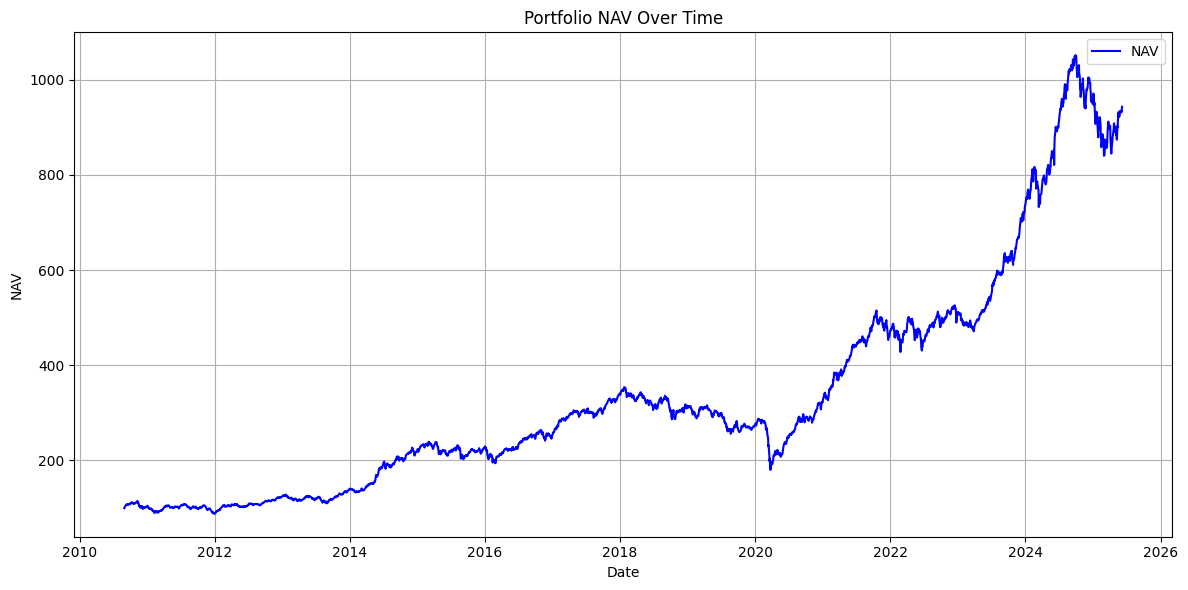

In [49]:
master_date = master_date.sort_values(by='Date')
portfolio = top_25_combined.groupby("Date")["Symbol"].apply(list).reset_index()

# Expand portfolio by date
merged = pd.merge_asof(master_date, portfolio, on="Date")

merged = merged.explode("Symbol").dropna(subset=["Symbol"])
merged = merged[merged["Date"]>= '2006-06-19'].reset_index(drop=True)
# Define the start date (it should start from 2006-06-19)
start_date = pd.to_datetime('2006-06-19')

# Filter the dates starting from 2006-06-19 (this ensures the start date is included)
filtered_dates = master_date[master_date['Date'] >= start_date]

# Ensure the start date is included
start_date_row = filtered_dates[filtered_dates['Date'] == start_date]

# Select every 50th date from the filtered dates (starting from the filtered list after the start date)
selected_dates = filtered_dates.iloc[::21*13]

# Combine the start date with the selected dates
selected_dates = pd.concat([start_date_row, selected_dates])

# Drop any NaN values and sort by date to ensure it's in the correct order
selected_dates = selected_dates.dropna().sort_values(by='Date')

combined_dates_portfolio = top_25_combined[top_25_combined['Date'].isin(selected_dates['Date'])]

# Make sure 'Date' is a column, not index
df_reset = df.reset_index()

# Merge with returns
merged = pd.merge(merged, df_reset[["Date", "Symbol", "returns"]], on=["Date", "Symbol"], how="left")

# Compute NAV (average return across stocks each date)
nav = merged.groupby("Date")["returns"].mean()

# Apply rebalance cost on rebalance dates
rebalance_dates = pd.to_datetime(selected_dates['Date']).tolist()
nav.loc[nav.index.isin(rebalance_dates)] -= 0.03

# Step 1: Compute NAV
nav = (1 + nav).cumprod() * 100

# Step 2: Plot NAV
plt.figure(figsize=(12, 6))
plt.plot(nav.index, nav.values, label='NAV', color='blue')
plt.title('Portfolio NAV Over Time')
plt.xlabel('Date')
plt.ylabel('NAV')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [50]:
# Ensure NAV is sorted
rebased_series = nav.sort_index()
daily_returns = rebased_series.pct_change().dropna()

# Compute overall metrics
start_date = rebased_series.index[0]
end_date = rebased_series.index[-1]
days = (end_date - start_date).days
years = days / 365.25

cagr = (rebased_series.iloc[-1] / rebased_series.iloc[0])**(1 / years) - 1
rolling_max = rebased_series.cummax()
drawdown = rebased_series / rolling_max - 1
mdd = drawdown.min()
volatility = daily_returns.std() * np.sqrt(252)

# Calendar Year Returns
cy_returns = rebased_series.resample('Y').last().pct_change().dropna()
cy_returns.index = cy_returns.index.year
cy_df = pd.DataFrame({'CY Return': cy_returns})

# Financial Year Returns (Apr–Mar)
fy_nav = rebased_series.copy()
fy_nav.index = fy_nav.index.to_period('M')
fy_ends = fy_nav.groupby(fy_nav.index.to_timestamp().to_period("A-MAR")).last()
fy_returns = fy_ends.pct_change().dropna()
fy_returns.index = fy_returns.index.year + 1
fy_df = pd.DataFrame({'FY Return': fy_returns})

# Monthly returns
monthly_periods = {
    '1M Return': 21,
    '2M Return': 42,
    '3M Return': 63,
    '6M Return': 126,
    '12M Return': 252,
    '24M Return': 504
}

monthly_data = []
for label, days_back in monthly_periods.items():
    if len(rebased_series) > days_back:
        ret = rebased_series.iloc[-1] / rebased_series.iloc[-days_back] - 1
        monthly_data.append({'Metric': label, 'Value': ret, 'Period': 'Latest'})

# Summary Metrics
summary_df = pd.DataFrame({
    'Metric': ['CAGR', 'Max Drawdown', 'Annualized Volatility'],
    'Value': [cagr, mdd, volatility],
    'Period': 'Overall'
})

# Calendar Year
cy_df_formatted = cy_df.rename_axis('Year').reset_index()
cy_df_formatted['Metric'] = 'CY Return'
cy_df_formatted = cy_df_formatted.rename(columns={'Year': 'Period', 'CY Return': 'Value'})

# Financial Year
fy_df_formatted = fy_df.rename_axis('Year').reset_index()
fy_df_formatted['Metric'] = 'FY Return'
fy_df_formatted = fy_df_formatted.rename(columns={'Year': 'Period', 'FY Return': 'Value'})

# Combine all
final_df = pd.concat([
    summary_df,
    pd.DataFrame(monthly_data),
    cy_df_formatted[['Metric', 'Period', 'Value']],
    fy_df_formatted[['Metric', 'Period', 'Value']]
], ignore_index=True)

# Optional: format as percentage
final_df['Value'] = final_df['Value'].apply(lambda x: f"{x:.2%}")

# Display
print(final_df)

                   Metric    Value   Period
0                    CAGR   16.42%  Overall
1            Max Drawdown  -49.10%  Overall
2   Annualized Volatility   14.85%  Overall
3               1M Return    7.90%   Latest
4               2M Return    7.32%   Latest
5               3M Return   11.34%   Latest
6               6M Return   -4.79%   Latest
7              12M Return   12.86%   Latest
8              24M Return   83.91%   Latest
9               CY Return  -15.13%     2011
10              CY Return   40.91%     2012
11              CY Return   12.75%     2013
12              CY Return   57.93%     2014
13              CY Return    2.98%     2015
14              CY Return   11.41%     2016
15              CY Return   34.11%     2017
16              CY Return   -7.46%     2018
17              CY Return  -12.97%     2019
18              CY Return   17.99%     2020
19              CY Return   46.08%     2021
20              CY Return    7.60%     2022
21              CY Return   44.2

In [26]:
benchmark = pd.read_excel('Nifty 200 Price Data_SI.xlsx')
benchmark = benchmark.set_index('Date')
benchmark

,Close
Date,
2004-01-01,1000.00
2004-01-02,1030.18
2004-01-05,1035.52
2004-01-06,1017.51
2004-01-07,1013.45
...,...
2025-05-28,13794.75
2025-05-29,13841.55
2025-05-30,13798.40


In [28]:
nav.index = pd.to_datetime(nav.index)


In [29]:
# Rebase benchmark NAV
benchmark_nav = benchmark['Close']
benchmark_nav = benchmark_nav[benchmark_nav.index >= '2006-06-19']
benchmark_nav = (benchmark_nav / benchmark_nav.iloc[0]) * 100
benchmark_nav = benchmark_nav.sort_index()

# Ensure rebased_series aligns
rebased_series = rebased_series[rebased_series.index.isin(benchmark_nav.index)]
benchmark_nav = benchmark_nav[benchmark_nav.index.isin(rebased_series.index)]

# Daily returns
strategy_returns = rebased_series.pct_change().dropna()
benchmark_returns = benchmark_nav.pct_change().dropna()
common_dates = strategy_returns.index.intersection(benchmark_returns.index)

# Performance metrics
def compute_metrics(nav, returns):
    start_date = nav.index[0]
    
    end_date = nav.index[-1]
    years = (end_date - start_date).days / 365.25

    cagr = (nav.iloc[-1] / nav.iloc[0])**(1 / years) - 1
    mdd = (nav / nav.cummax() - 1).min()
    volatility = returns.std() * np.sqrt(252)

    return cagr, mdd, volatility

strategy_cagr, strategy_mdd, strategy_vol = compute_metrics(rebased_series, strategy_returns)
benchmark_cagr, benchmark_mdd, benchmark_vol = compute_metrics(benchmark_nav, benchmark_returns)

# Side-by-side comparison
comparison_df = pd.DataFrame({
    'Metric': ['CAGR', 'Max Drawdown', 'Annualized Volatility'],
    'Strategy': [strategy_cagr, strategy_mdd, strategy_vol],
    'Benchmark': [benchmark_cagr, benchmark_mdd, benchmark_vol]
})
comparison_df['Alpha'] = comparison_df['Strategy'] - comparison_df['Benchmark']
comparison_df[['Strategy', 'Benchmark', 'Alpha']] = comparison_df[['Strategy', 'Benchmark', 'Alpha']].applymap(lambda x: f"{x:.2%}")

# Rolling return analysis
rolling_windows = {'1Y': 252, '3Y': 252*3, '5Y': 252*5}
rolling_data = []

for label, window in rolling_windows.items():
    if len(rebased_series) > window:
        strat_rolling_cagr = (rebased_series / rebased_series.shift(window)).dropna() ** (252 / window) - 1
        bench_rolling_cagr = (benchmark_nav / benchmark_nav.shift(window)).dropna() ** (252 / window) - 1

        common_idx = strat_rolling_cagr.index.intersection(bench_rolling_cagr.index)
        strat_rolling_cagr = strat_rolling_cagr.loc[common_idx]
        bench_rolling_cagr = bench_rolling_cagr.loc[common_idx]
        alpha = strat_rolling_cagr - bench_rolling_cagr

        rolling_data.extend([
            {'Metric': f'{label} Rolling CAGR Mean', 'Value': strat_rolling_cagr.mean(), 'Period': 'Rolling'},
            {'Metric': f'{label} Rolling CAGR Median', 'Value': strat_rolling_cagr.median(), 'Period': 'Rolling'},
            {'Metric': f'{label} Rolling Alpha Mean', 'Value': alpha.mean(), 'Period': 'Rolling'},
            {'Metric': f'{label} Rolling Alpha Median', 'Value': alpha.median(), 'Period': 'Rolling'}
        ])

# Positive quarters and alpha quarters
quarterly_strat = rebased_series.resample('Q').last().pct_change().dropna()
quarterly_bench = benchmark_nav.resample('Q').last().pct_change().dropna()

common_qtr = quarterly_strat.index.intersection(quarterly_bench.index)
quarterly_strat = quarterly_strat.loc[common_qtr]
quarterly_bench = quarterly_bench.loc[common_qtr]
quarterly_alpha = quarterly_strat - quarterly_bench

pos_quarters = (quarterly_strat > 0).mean()
pos_alpha_quarters = (quarterly_alpha > 0).mean()

pos_df = pd.DataFrame([
    {'Metric': '% Positive Quarters', 'Value': pos_quarters, 'Period': 'Quarterly'},
    {'Metric': '% Alpha Quarters', 'Value': pos_alpha_quarters, 'Period': 'Quarterly'}
])

# Monthly return metrics
monthly_periods = {
    '1M Return': 21,
    '2M Return': 42,
    '3M Return': 63,
    '6M Return': 126,
    '12M Return': 252,
    '24M Return': 504
}

monthly_data = []
for label, days_back in monthly_periods.items():
    if len(rebased_series) > days_back:
        ret = rebased_series.iloc[-1] / rebased_series.iloc[-days_back] - 1
        monthly_data.append({'Metric': label, 'Value': ret, 'Period': 'Latest'})

# Calendar Year Returns
cy_returns = rebased_series.resample('Y').last().pct_change().dropna()
cy_returns.index = cy_returns.index.year
cy_df = pd.DataFrame({'CY Return': cy_returns})
cy_df_formatted = cy_df.rename_axis('Year').reset_index()
cy_df_formatted['Metric'] = 'CY Return'
cy_df_formatted = cy_df_formatted.rename(columns={'Year': 'Period', 'CY Return': 'Value'})

# Financial Year Returns
fy_nav = rebased_series.copy()
fy_nav.index = fy_nav.index.to_period('M')
fy_ends = fy_nav.groupby(fy_nav.index.to_timestamp().to_period("A-MAR")).last()
fy_returns = fy_ends.pct_change().dropna()
fy_returns.index = fy_returns.index.year + 1
fy_df = pd.DataFrame({'FY Return': fy_returns})
fy_df_formatted = fy_df.rename_axis('Year').reset_index()
fy_df_formatted['Metric'] = 'FY Return'
fy_df_formatted = fy_df_formatted.rename(columns={'Year': 'Period', 'FY Return': 'Value'})

# Summary Metrics
summary_df = pd.DataFrame({
    'Metric': ['CAGR', 'Max Drawdown', 'Annualized Volatility'],
    'Value': [strategy_cagr, strategy_mdd, strategy_vol],
    'Period': 'Overall'
})

# Final metrics DataFrame
metrics_df = pd.concat([
    summary_df,
    pd.DataFrame(monthly_data),
    pd.DataFrame(rolling_data),
    pos_df,
    cy_df_formatted[['Metric', 'Period', 'Value']],
    fy_df_formatted[['Metric', 'Period', 'Value']]
], ignore_index=True)

metrics_df['Value'] = metrics_df['Value'].apply(lambda x: f"{x:.2%}")
comparison_df, metrics_df

IndexError: index 0 is out of bounds for axis 0 with size 0

In [52]:
final_df

,Metric,Value,Period
0,CAGR,16.42%,Overall
1,Max Drawdown,-49.10%,Overall
2,Annualized Volatility,14.85%,Overall
3,1M Return,7.90%,Latest
4,2M Return,7.32%,Latest
5,3M Return,11.34%,Latest
6,6M Return,-4.79%,Latest
7,12M Return,12.86%,Latest
8,24M Return,83.91%,Latest
9,CY Return,-15.13%,2011


In [44]:
ivolnse = nav.to_frame(name='IVOLNSEDiv')
ivolnse

,IVOLNSEDiv
Date,
2010-08-31,99.688106
2010-09-01,101.161881
2010-09-02,102.290256
2010-09-03,103.163798
2010-09-06,104.486397
...,...
2025-04-29,1132.353227
2025-04-30,1120.994717
2025-05-02,1118.816853


In [45]:
ivolnse.to_csv('IVOLNSEDiv.csv')

In [24]:
dividend =  pd.read_csv('Full_appender-2.csv')
dividend = dividend[['Date', 'Symbol','LowVol']]
dividend['Date'] = pd.to_datetime(dividend['Date'])

top_50a = (
    dividend[['Date', 'Symbol', 'LowVol']]
      .sort_values(['Date', 'LowVol'], ascending=[True, False])
      .groupby('Date')
      .head(50)
      .reset_index(drop=True)
)
top_50a['Date'] = pd.to_datetime(top_50a['Date'])
top_50a

,Date,Symbol,LowVol
0,2006-01-03,MORGANSTAN,1.000000
1,2006-01-03,ASIANPAINT,0.997561
2,2006-01-03,GSKCONS,0.995122
3,2006-01-03,GRASIM,0.992683
4,2006-01-03,IOC,0.990244
...,...,...,...
240595,2025-06-04,PAGEIND,0.904863
240596,2025-06-04,INFY,0.902748
240597,2025-06-04,BATAINDIA,0.900634
240598,2025-06-04,HAVELLS,0.898520


In [46]:
combined_dates_portfolio.to_csv('IVOLNSEDivPortfolio.csv', index=False)

In [38]:
combined_dates_portfolio

,Date,Symbol
0,2010-08-31,VSTIND
1,2010-08-31,CRISIL
2,2010-08-31,SOUTHBANK
3,2010-08-31,TATACONSUM
4,2010-08-31,TATASTEEL
...,...,...
27295,2011-09-30,HAVELLS
27296,2011-09-30,POLARIS
27297,2011-09-30,ITC
27298,2011-09-30,NIITLTD
